<a href="https://colab.research.google.com/github/egafdharmawan/ChiSquare_StatsTesting/blob/main/Chi_Square_Stats_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Import Modules

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

## 01 . Dataset

In [23]:
path = 'https://raw.githubusercontent.com/egafdharmawan/ChiSquare_StatsTesting/main/transactions_dataset.csv'
data = pd.read_csv(path)
data.head()

,user_id,date_transaction,revenue,product_category
0,user_454,2024-04-17,51.91,Toys
1,user_254,2024-03-25,80.96,Books
2,user_500,2024-05-05,7.31,Home
3,user_633,2024-04-07,443.25,Clothing
4,user_531,2024-05-17,497.89,Electronics


# B. Data Preprocessing

## 01 . EDA

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           4000 non-null   object 
 1   date_transaction  4000 non-null   object 
 2   revenue           4000 non-null   float64
 3   product_category  4000 non-null   object 
dtypes: float64(1), object(3)
memory usage: 125.1+ KB


In [ ]:
# Change Date Type
data['date_transaction'] = pd.to_datetime(data['date_transaction']).dt.date

<Axes: xlabel='date_transaction', ylabel='revenue'>

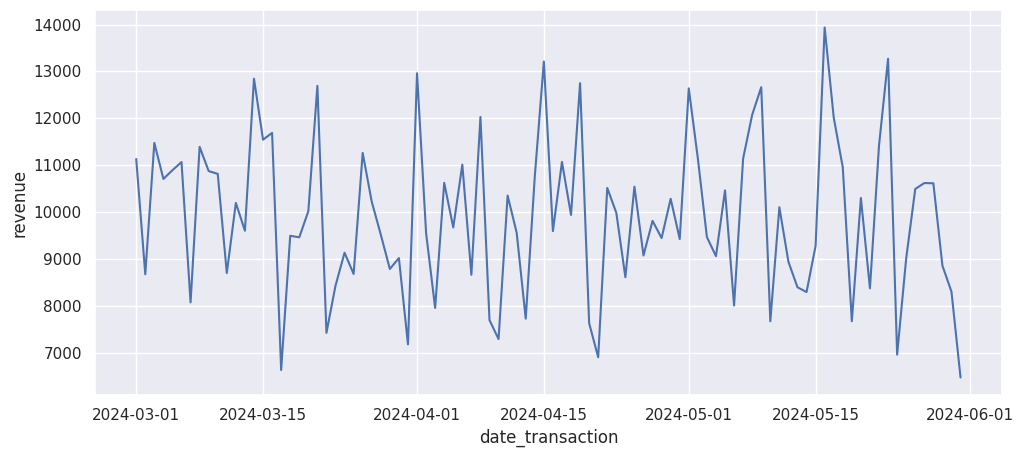

In [33]:
# Revenue Over Time
gb = data[['date_transaction','revenue']].groupby(['date_transaction'])['revenue'].sum().reset_index()
sns.set_theme(rc={'figure.figsize':(11.7,5)})
sns.lineplot(data=gb, x="date_transaction", y="revenue")

<Axes: xlabel='date_transaction', ylabel='revenue'>

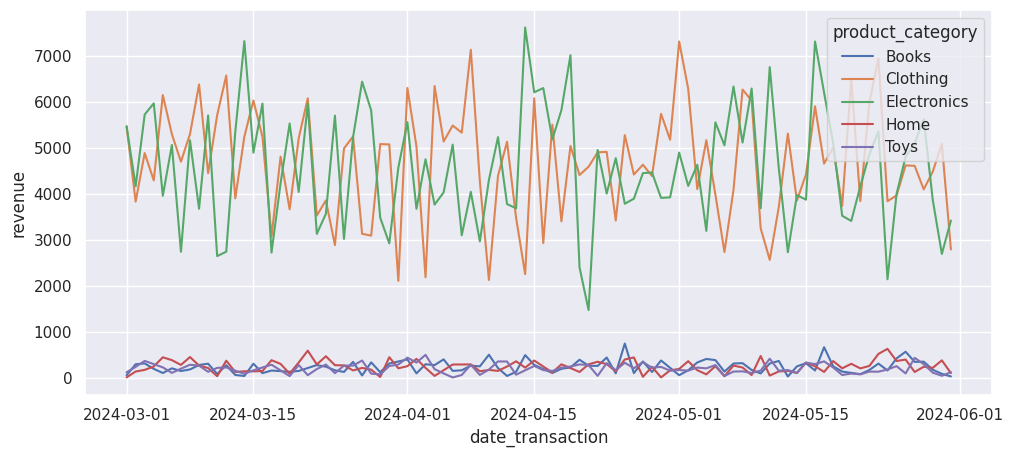

In [34]:
# Product Distribution
gb = data[['date_transaction','product_category','revenue']].groupby(['date_transaction','product_category'])['revenue'].sum().reset_index()
sns.set_theme(rc={'figure.figsize':(11.7,5)})
sns.lineplot(data=gb, x="date_transaction", y="revenue", hue="product_category")

## 02 . RFM Segment

In [35]:
def RFMSegmentation(data):
  # Frequency
  freq = pd.DataFrame(data.groupby(['user_id'])['date_transaction'].count().reset_index())
  freq.columns = ['user_id','Frequency']
  freq['F'] = pd.qcut(freq['Frequency'], 3, labels=[1,2,3])

  # Recency
  maxDate = data['date_transaction'].max()
  rec = pd.DataFrame(data.groupby(['user_id'])['date_transaction'].max().reset_index())
  rec['Diff'] = maxDate - rec['date_transaction']
  rec['Diff'] = rec['Diff'].astype(str).str.replace('0:00:00', '0 days')
  rec['Diff'] = rec['Diff'].astype(str).str.split(' ').str[0].astype(int)
  rec.columns = ['user_id','LatestDate', 'Recency']
  rec['R'] = pd.qcut(rec['Recency'].rank(method='first'), 3, labels=[3,2,1])

  # Monetary
  mon = pd.DataFrame(data.groupby(['user_id'])['revenue'].sum().reset_index())
  mon.columns = ['user_id','Monetary']
  mon['M'] = pd.qcut(mon['Monetary'], 3, labels=[1,2,3])

  # RFM
  RFM = rec.merge(freq, on='user_id')
  RFM = RFM.merge(mon, on='user_id')
  RFM['RFM'] = RFM['R'].astype(str) + '' + RFM['F'].astype(str) + '' + RFM['M'].astype(str)

  return RFM

In [36]:
def assign_segment(cluster_centers):
    segments = []
    for idx, row in cluster_centers.iterrows():
        if row['R'] >= 3 and row['F'] >= 3 and row['M'] >= 3:
            segments.append("Champion")
        elif row['R'] >= 2 or row['F'] >= 2:
            segments.append("Loyal Customers")
        elif row['R'] == 1 and row['F'] == 1 and row['M'] == 1:
            segments.append("Hibernating")
        else:
            segments.append("Potential Loyalists")
    return segments

In [42]:
# Generate RFM table each user
rfm = RFMSegmentation(data)

# group by 5 category
rfm['Segment'] = assign_segment(rfm)
rfm = rfm[['user_id','Segment']]
rfm.head()

,user_id,Segment
0,user_1,Loyal Customers
1,user_10,Loyal Customers
2,user_100,Loyal Customers
3,user_101,Loyal Customers
4,user_102,Champion


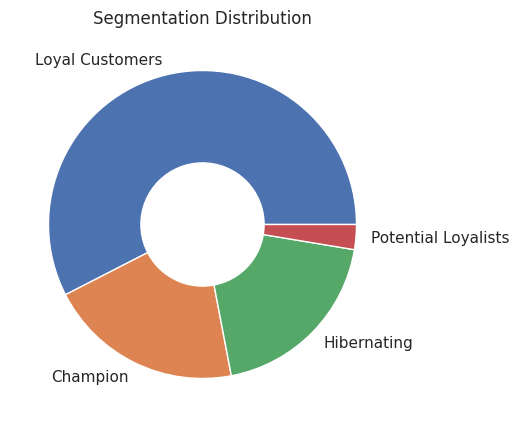

In [41]:
# Check RFM Distribution
plt.pie(rfm['Segment'].value_counts(),
        labels=rfm['Segment'].value_counts().index.tolist())
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Segmentation Distribution')
plt.show()

## 03 . Customer Preferred Products

In [44]:
# find most bought product category each user Preference product
prod = data[['user_id','product_category','date_transaction']].groupby(['user_id','product_category'])['date_transaction'].count().reset_index()
prod.columns = ['user_id','preferred_category','value']
prod = prod.groupby(['user_id']).max().reset_index()
prod.drop(['value'], axis=1, inplace=True)

# Join All Columns
final = prod.merge(rfm, on='user_id', how='left')
final.head()

,user_id,preferred_category,Segment
0,user_1,Home,Loyal Customers
1,user_10,Electronics,Loyal Customers
2,user_100,Toys,Loyal Customers
3,user_101,Home,Loyal Customers
4,user_102,Electronics,Champion


<Axes: ylabel='preferred_category'>

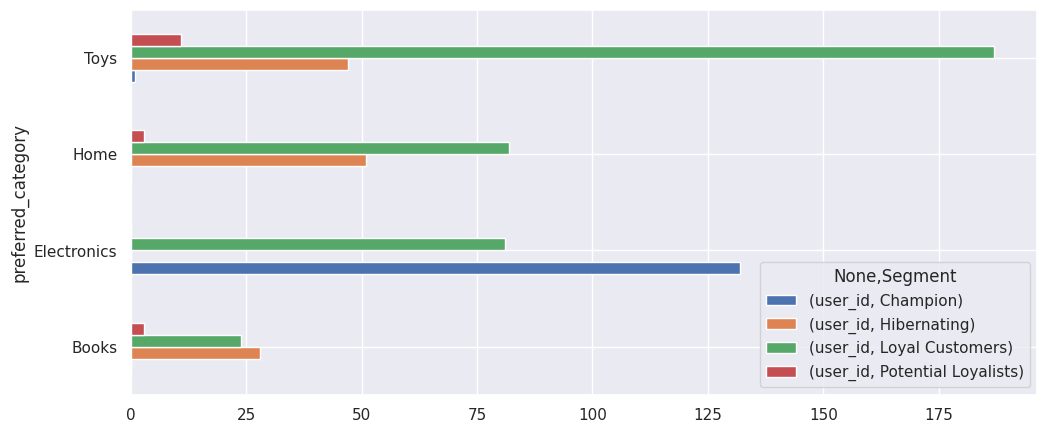

In [54]:
# On Product level
final.groupby(['Segment','preferred_category']).count().unstack(0).plot.barh()

# C. Chi Square Test

## a. Define Hypothesis

In [83]:
# Ho : No Significant Association between product and RFM Segment
# H1 : There is a Significant Association between product and RFM Segment

## b. Chi Squared Assumption Test

### 1 . Check for Outlier and Null Values

<Axes: xlabel='Segment', ylabel='count'>

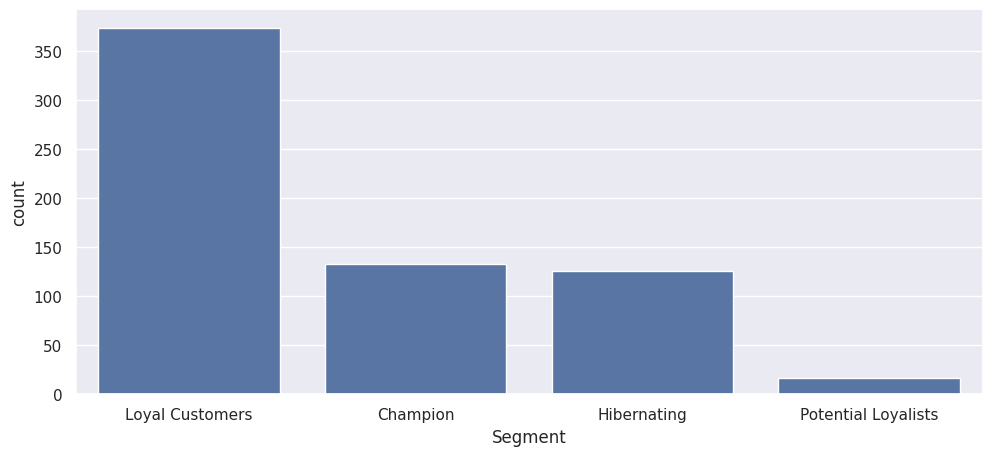

In [92]:
# Outlier
sns.countplot(data=final, x="Segment")

<Axes: xlabel='preferred_category', ylabel='count'>

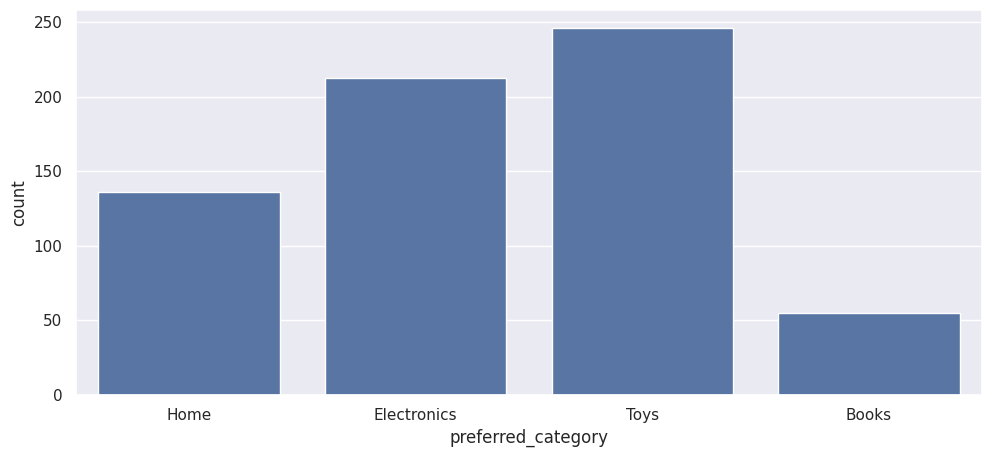

In [103]:
sns.countplot(data=final, x="preferred_category")

In [113]:
final = final[final['Segment'] != 'Potential Loyalists']

In [114]:
# Null Values
print(final.isnull().sum())

user_id               0
preferred_category    0
Segment               0
dtype: int64


### 2 . Cramer's V (Independence Test)

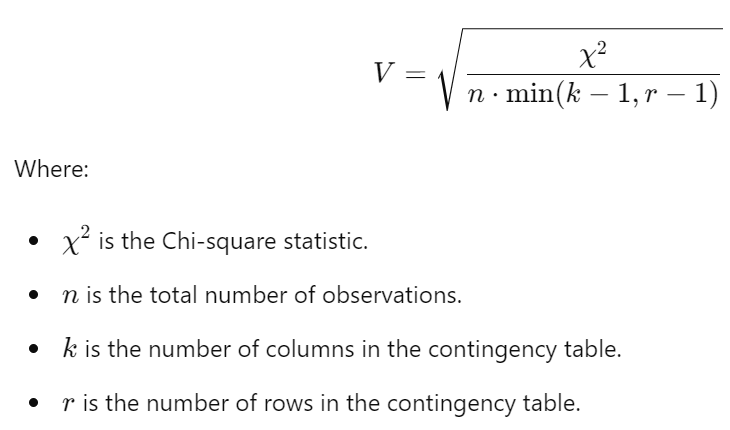

In [115]:
# Check for independence (Cramer's V)
contingency_table = pd.crosstab(final['Segment'], final['preferred_category'])
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers_v_value = cramers_v(contingency_table)
print("Contingency Table")
print("")
print(contingency_table)
print("")
print("Cramer's value")
print(cramers_v_value)

Contingency Table

preferred_category  Books  Electronics  Home  Toys
Segment                                           
Champion                0          132     0     1
Hibernating            28            0    51    47
Loyal Customers        24           81    82   187

Cramer's value
0.5520820979833589


### 3 . Expected Cell Frequency

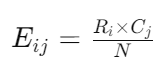

In [116]:
# Expected Cell Frequency
total_obs = contingency_table.values.sum()
row_totals = contingency_table.sum(axis=1)
col_totals = contingency_table.sum(axis=0)
expected_table = np.outer(row_totals, col_totals) / total_obs
print(expected_table)

[[ 10.92575039  44.7535545   27.94470774  49.37598736]
 [ 10.3507109   42.39810427  26.47393365  46.77725118]
 [ 30.7235387  125.84834123  78.58135861 138.84676145]]


## c. Chi Squared Test

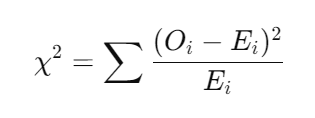

In [119]:
# Calculate Chi Square Statistics
(((contingency_table-expected_table)**2)/expected_table).sum().sum()

385.8700179287532

In [120]:
# Perform Chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-square Statistic:", chi2_stat)
print("p-value:", p_val)
print("Degrees of Freedom:", dof)

# Interpret the results
alpha = 0.05
if p_val < alpha:
    print("\nThe variables are not independent (significant association).")
else:
    print("\nThe variables are independent (no significant association).")

Chi-square Statistic: 385.8700179287532
p-value: 3.045679647929042e-80
Degrees of Freedom: 6

The variables are not independent (significant association).


## d. Result

There is enough evidence to prove that the association between two categorical is significant